In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from tqdm.auto import tqdm
from torch.optim.lr_scheduler import StepLR
from collections import Counter
import os
import random

In [2]:
# Function to create a PyTorch dataset from CSV files
def create_torch_dataset(size=561):
    all_data = []
    scaler = MinMaxScaler()
    columns = ['Input Voltage', 'Output Voltage', 'Tachometer']
    num_rows = 122824

    for run in range(1, size):
        file_path = f'../PHM09_competition_1/Run_{run}.csv'
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            continue

        temp_df = pd.read_csv(file_path, names=columns, nrows=num_rows)
        normalized_data = scaler.fit_transform(temp_df)
        temp_tensor = torch.tensor(normalized_data, dtype=torch.float32)
        all_data.append(temp_tensor)
    
    all_data_tensor = torch.stack(all_data, dim=0)
    return all_data_tensor

train = True 
dataset_tensor = create_torch_dataset()
print(f"Dataset tensor shape {dataset_tensor.shape}")

Dataset tensor shape torch.Size([560, 122824, 3])


In [12]:
# LSTM Encoder class
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x):
        outputs, hidden = self.lstm(x)
        return hidden  # Return the hidden state for the decoder to use
        
# LSTM Decoder class
class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        output, hidden = self.lstm(x, hidden)
        return self.linear(output)
        
# Main model class for Gearbox Fault Detection
class GearboxFaultDetectionLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(GearboxFaultDetectionLSTM, self).__init__()
        self.encoder = Encoder(input_size, hidden_size, num_layers)
        self.decoder = Decoder(input_size, hidden_size, num_layers, input_size)

    def forward(self, x):
        # Decoder takes the input sequence again and the hidden state from the encoder
        return self.decoder(x, self.encoder(x))

print(f"Dataset tensor shape {dataset_tensor.shape}")

In [4]:
def save_model(model, optimizer, epoch, loss, base_file_path='model_checkpoint'):
    state_dict_path = f"{base_file_path}_epoch_{epoch}_state.pth"
    full_model_path = f"{base_file_path}_epoch_{epoch}_full.pth"

    # Save the model state dict and optimizer state dict
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, state_dict_path)

    # Save the entire model
    torch.save(model, full_model_path)

    print(f"Model state dict saved to {state_dict_path}")
    print(f"Full model saved to {full_model_path}")

def load_model(model, optimizer, file_path='model_checkpoint.pth'):
    checkpoint = torch.load(file_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print("Model loaded successfully")
    return model, optimizer, epoch, loss

In [ ]:
%%time 
def preprocess_data(data, subsequence_length=1024):
    # data is of shape [batch_size, sequence_length, feature_size]
    batch_size, sequence_length, feature_size = data.shape

    # Determine the number of subsequences we can get from each sequence
    num_subsequences_per_sequence = sequence_length // subsequence_length

    # Calculate new shape
    new_batch_size = batch_size * num_subsequences_per_sequence
    new_sequence_length = subsequence_length

    # Reshape data
    reshaped_data = data.unfold(1, new_sequence_length, new_sequence_length)
    reshaped_data = reshaped_data.contiguous().view(new_batch_size, new_sequence_length, feature_size)
    print(reshaped_data.shape)
    return reshaped_data

def train_model(model, train_dataset, val_dataset, **params):
    n_epochs = params['n_epochs']
    step_size = params['step_size']
    gamma = params['gamma']
    patience = params['patience']
    
    best_loss = float('inf')
    patience_counter = 0
    history = {'train': [], 'val': []}
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
    
    loss_fn = nn.L1Loss(reduction='sum')

    for epoch in range(1, n_epochs + 1):
        model.train()
        train_loss = []
        for seq_true in train_dataset:
            try:
                optimizer.zero_grad()
                seq_pred = model(seq_true)
                loss = loss_fn(seq_pred, seq_true)
                loss.backward()
                optimizer.step()
                train_loss.append(loss.item())
            except RuntimeError as e:
                print(f"Runtime error during training: {e}")
                continue

        scheduler.step()
        # Eval loop 
        val_loss = []
        model.eval()
        with torch.no_grad():
            for seq_true in val_dataset:
                seq_pred = model(seq_true)
                loss = loss_fn(seq_pred, seq_true)
                val_loss.append(loss.item())
            
        avg_train_loss = sum(train_loss) / len(train_loss)
        avg_val_loss = sum(val_loss) / len(val_loss)
        history['train'].append(avg_train_loss)
        history['val'].append(avg_val_loss)

        print(f'Epoch {epoch}: train loss {avg_train_loss} val loss {avg_val_loss}')

        # Early stopping check
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            patience_counter = 0  # reset counter if performance improved
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch} epochs.')
                break  # stop training if patience limit is reached

    final_loss = best_loss  # The best recorded loss
    return model, optimizer, history, final_loss


preprocessed_dataset_tensor = preprocess_data(dataset_tensor)

# Prepare DataLoaders
train_size = int(0.8 * len(preprocessed_dataset_tensor))
val_size = len(preprocessed_dataset_tensor) - train_size

train_dataset, val_dataset = random_split(preprocessed_dataset_tensor, [train_size, val_size])



hyper_params = {
    'batch_size':32,
    'patience': 3,
    'step_size': 7,  # Adjust learning rate every X epochs
    'gamma': 0.05,  # Reduce learning rate to X% of previous
    'n_epochs': 15,
    'input_size': 3,  # As there are 3 features in each timestep
    'hidden_size': 32,  # Tune this based on the complexity of the data
    'num_layers': 2   # Number of LSTM layers
}

train_dataloader = DataLoader(train_dataset, batch_size=hyper_params['batch_size'], shuffle=False ,num_workers=os.cpu_count() )
val_dataloader = DataLoader(val_dataset, batch_size=hyper_params['batch_size'] ,num_workers=os.cpu_count())

model = GearboxFaultDetectionLSTM(hyper_params['input_size'],hyper_params['hidden_size'],hyper_params['num_layers'])


model, optimizer, history, final_loss = train_model(model, train_dataloader, val_dataloader, **hyper_params)
try:
    save_model(model, optimizer, hyper_params['n_epochs'], final_loss)
except:
    pass

torch.Size([66640, 1024, 3])
Epoch 1: train loss 2562.3625544700303 val loss 835.9249315879327
Epoch 2: train loss 678.4787386634341 val loss 540.8959070292594
Epoch 3: train loss 500.4821586288324 val loss 583.2168157563792
Epoch 4: train loss 506.1103609412515 val loss 435.9300654569118
Epoch 5: train loss 467.3302443413889 val loss 419.2200090513527
Epoch 6: train loss 417.53795487311135 val loss 385.9897006467092
Epoch 7: train loss 322.0311253651851 val loss 280.9064546946427


In [ ]:
def threshold_plot(save = False):
    # This plot should help to choose the THRESHOLD
    ax = plt.figure().gca()
    ax.plot(history['train'])
    ax.plot(history['val'])
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'])
    plt.title('Loss over training epochs')
    if save:
        plt.savefig(f'../img/loss_plot_{hyper_params["n_epochs"]}.png')
    plt.show()

threshold_plot()

In [12]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum') # MAE should we check also L2(MSE) and Huber Loss / nn.BCELoss() binray cross entorpy 
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true
      seq_pred = model(seq_true)
      loss = criterion(seq_pred, seq_true)
      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
      result_df = pd.DataFrame({
        'Run_id': range(1, len(predictions) + 1),
        'Loss':losses,
    })
  return result_df , predictions, losses

df_pred ,predictions, losses = predict(model, dataset_tensor)

<Axes: ylabel='Count'>

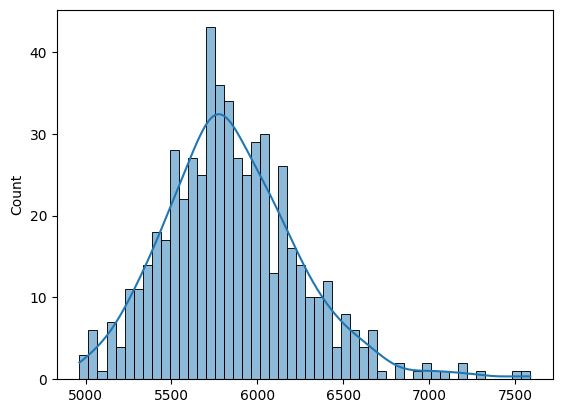

In [59]:
sns.histplot(losses, bins=50, kde=True) 
# if train == True
#     plt.savefig(f'../img/threshold_plot_{hyper_params["n_epochs"]}.png')

In [13]:
THRESHOLD = 6560
start_normal = 5800
end_noraml = 5850
correct = sum(l <= THRESHOLD for l in losses)
print(f"Total normal {correct}\nTotal abnormal {560-correct}")
anomaly = df_pred[df_pred['Loss'] >= THRESHOLD].index
normal = df_pred[(df_pred['Loss'] >= start_normal) & (df_pred['Loss'] < end_noraml) ].index
anomaly_list = list(anomaly)
print(f"Anomaly list (index): {anomaly_list}")
print(f"Normal list (index): {list(normal)}")

In [7]:
def append_to_csv(data):
    new_data = pd.DataFrame(data)
    try:
        existing_data = pd.read_csv('anomaly_results.csv')
        if data['model'][0] in existing_data['model'].values:
            existing_data.loc[existing_data['model'] == data['model'][0]] = new_data.values
        else:
            existing_data = pd.concat([existing_data, new_data], ignore_index=True)
    except FileNotFoundError:
        existing_data = new_data
    existing_data.to_csv('anomaly_results.csv', index=False)
    return existing_data

df = append_to_csv(data)
df

,model,anomalies,length,params,hyper_params
0,IsolationForest,"[9, 53, 79, 84, 125, 149, 162, 172, 174, 179, ...",23,"{'n_estimators': 50, 'max_samples': 0.25, 'con...",NaN
1,Autoencoder,"[53, 82, 88, 111, 155, 162, 192, 195, 207, 269...",26,<bound method Module.parameters of Autoencoder...,"{'batch_size': 32, 'n_epochs': 100, 'loss_fn':..."
2,LSTM,"[37, 53, 68, 82, 91, 99, 103, 179, 195, 197, 2...",26,<bound method Module.parameters of GearboxFaul...,"{'batch_size': 32, 'patience': 3, 'step_size':..."


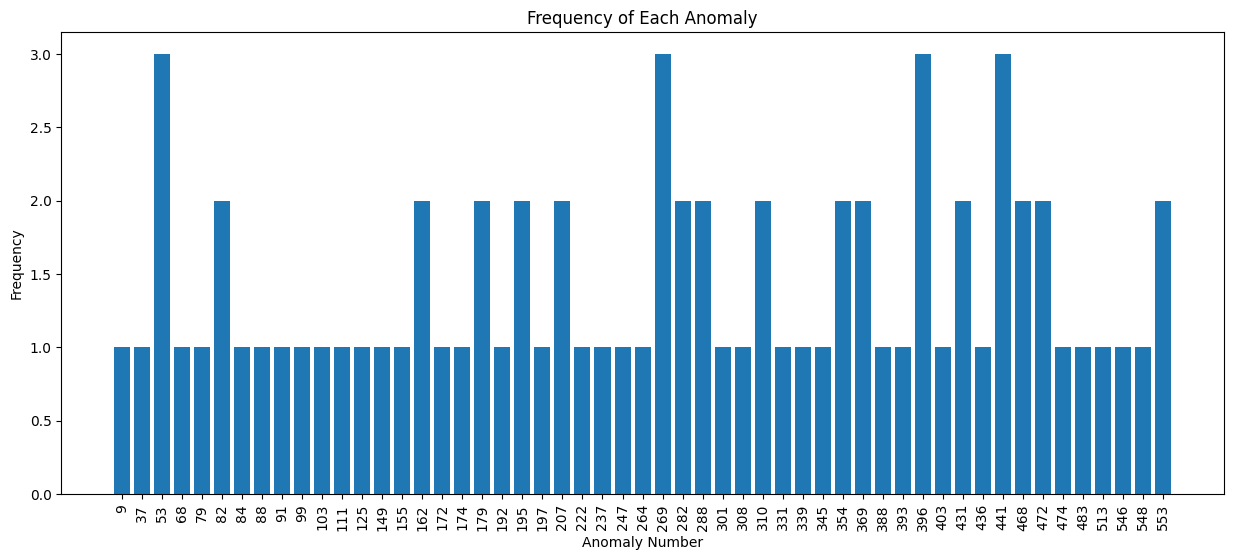

In [11]:
def plot_anomaly_frequency_sorted(df, save =True):
    all_anomalies = []
    for item in df['anomalies']:
        if type(item) == str:
            item = [int(num.strip()) for num in item.strip("[]").split(',')]
        all_anomalies += item
    anomaly_counts = Counter(all_anomalies)
    sorted_filtered_counts = dict(sorted(anomaly_counts.items()))
    categories = list(sorted_filtered_counts.keys())
    frequencies = list(sorted_filtered_counts.values())
     # Plotting
    plt.figure(figsize=(15, 6))
    plt.bar([str(category) for category in categories], frequencies)  # Converting categories to string
    plt.xlabel('Anomaly Number')
    plt.ylabel('Frequency')
    plt.title('Frequency of Each Anomaly')
    plt.xticks(rotation=90) 
    
    if save:
        plt.savefig(f'../img/frequency_anomalies.png')
    plt.show()

plot_anomaly_frequency_sorted(df)